# Creating a model for Loan Sanction ammount Prediction
data from https://www.kaggle.com/datasets/boss0ayush/loan-sanction-amount-prediction-data/

Importing all the Library Needed

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import  GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from scipy import stats
import math

import gdown

Loading the data to colab

you can change this block of code depending on how your loading your data, I'am using Google drive

In [27]:
def load_data(link):
    # Extract file ID from the provided link
    file_id = link.split('/')[-2]

    # Generate direct download link
    csv_link = f'https://drive.google.com/uc?id={file_id}'

    # Download the CSV file
    gdown.download(csv_link, f'{file_id}.csv', quiet=False)

    # Read the CSV file
    df = pd.read_csv(f'{file_id}.csv', encoding='utf-8')

    return df

# Use the provided links
test_link = 'https://drive.google.com/file/d/1yBo9nHWOe4C8HKjMsdP-5OQ299xP_FST/view?usp=sharing'

train_link = 'https://drive.google.com/file/d/14y-1O6ur9vERuQHeQSjCMtKuBy7e2zb4/view?usp=sharing'

# Load the data
test = load_data(test_link)

train = load_data(train_link)

Downloading...
From: https://drive.google.com/uc?id=1yBo9nHWOe4C8HKjMsdP-5OQ299xP_FST
To: /content/1yBo9nHWOe4C8HKjMsdP-5OQ299xP_FST.csv
100%|██████████| 2.87M/2.87M [00:00<00:00, 195MB/s]
Downloading...
From: https://drive.google.com/uc?id=14y-1O6ur9vERuQHeQSjCMtKuBy7e2zb4
To: /content/14y-1O6ur9vERuQHeQSjCMtKuBy7e2zb4.csv
100%|██████████| 4.48M/4.48M [00:00<00:00, 129MB/s]


In [28]:
train.head()

,Customer ID,Name,Gender,Age,Income (USD),Income Stability,Profession,Type of Employment,Location,Loan Amount Request (USD),...,Credit Score,No. of Defaults,Has Active Credit Card,Property ID,Property Age,Property Type,Property Location,Co-Applicant,Property Price,Loan Sanction Amount (USD)
0,C-36995,Frederica Shealy,F,56,1933.05,Low,Working,Sales staff,Semi-Urban,72809.58,...,809.44,0,NaN,746,1933.05,4,Rural,1,119933.46,54607.18
1,C-33999,America Calderone,M,32,4952.91,Low,Working,NaN,Semi-Urban,46837.47,...,780.40,0,Unpossessed,608,4952.91,2,Rural,1,54791.00,37469.98
2,C-3770,Rosetta Verne,F,65,988.19,High,Pensioner,NaN,Semi-Urban,45593.04,...,833.15,0,Unpossessed,546,988.19,2,Urban,0,72440.58,36474.43
3,C-26480,Zoe Chitty,F,65,NaN,High,Pensioner,NaN,Rural,80057.92,...,832.70,1,Unpossessed,890,NaN,2,Semi-Urban,1,121441.51,56040.54
4,C-23459,Afton Venema,F,31,2614.77,Low,Working,High skill tech staff,Semi-Urban,113858.89,...,745.55,1,Active,715,2614.77,4,Semi-Urban,1,208567.91,74008.28


# Data Preprocessing Part 1

In [29]:
#Check the number of unique value from all of the object datatype
train.select_dtypes(include='object').nunique()

,0
Customer ID,30000
Name,30000
Gender,2
Income Stability,2
Profession,8
Type of Employment,18
Location,3
Expense Type 1,2
Expense Type 2,2
Has Active Credit Card,3


In [30]:
# Check the amounnt of missing value
check_missing = train.isnull().sum() * 100 / train.shape[0]
check_missing[check_missing > 0].sort_values(ascending=False)

,0
Type of Employment,24.233333
Property Age,16.166667
Income (USD),15.253333
Dependents,8.310000
Credit Score,5.676667
Income Stability,5.610000
Has Active Credit Card,5.220000
Property Location,1.186667
Loan Sanction Amount (USD),1.133333
Current Loan Expenses (USD),0.573333


In [31]:
def preprocess_data(df):
    # Remove identifier columns
    df.drop(columns=['Customer ID', 'Name'], inplace=True)

    # Segment Type of Employment into smaller unique values
    df['Type of Employment'] = df['Type of Employment'].apply(segment_employment_type)



    # Handle missing values
    df.fillna({
        'Property Age': df['Property Age'].median(),
        'Income (USD)': df['Income (USD)'].median(),
        'Dependents': df['Dependents'].median(),
        'Credit Score': df['Credit Score'].median(),
        'Loan Sanction Amount (USD)': df['Loan Sanction Amount (USD)'].median(),
        'Current Loan Expenses (USD)': df['Current Loan Expenses (USD)'].median()
    }, inplace=True)

    df.dropna(subset=['Income Stability', 'Has Active Credit Card', 'Property Location', 'Gender'], inplace=True)

    return df.head(10)

# Segment Type of Employment into smaller unique value

In [32]:
train['Type of Employment'].unique()

array(['Sales staff', nan, 'High skill tech staff', 'Secretaries',
       'Laborers', 'Managers', 'Cooking staff', 'Core staff', 'Drivers',
       'Realty agents', 'Security staff', 'Accountants',
       'Private service staff', 'Waiters/barmen staff', 'Medicine staff',
       'Cleaning staff', 'Low-skill Laborers', 'HR staff', 'IT staff'],
      dtype=object)

In [33]:
def segment_employment_type(value):
    if pd.isna(value):
        return 'Unknown'
    elif 'Sales' in value or 'Realty' in value:
        return 'Sales/Realty'
    elif 'Tech' in value or 'IT' in value:
        return 'Tech/IT'
    elif 'Secretaries' in value or 'HR' in value:
        return 'Secretaries/HR'
    elif 'Laborers' in value or 'Low-skill Laborers' in value:
        return 'Laborers'
    elif 'Managers' in value:
        return 'Managers'
    elif 'Cooking' in value or 'Waiters/barmen' in value:
        return 'Hospitality'
    else:
        return 'Other'

In [34]:
# Apply the function to create a new column
train['Type of Employment'] = train['Type of Employment'].apply(segment_employment_type)

In [35]:
preprocess_data(train)

,Gender,Age,Income (USD),Income Stability,Profession,Type of Employment,Location,Loan Amount Request (USD),Current Loan Expenses (USD),Expense Type 1,...,Credit Score,No. of Defaults,Has Active Credit Card,Property ID,Property Age,Property Type,Property Location,Co-Applicant,Property Price,Loan Sanction Amount (USD)
1,M,32,4952.910,Low,Working,Other,Semi-Urban,46837.47,495.81,N,...,780.40,0,Unpossessed,608,4952.91,2,Rural,1,54791.00,37469.98
2,F,65,988.190,High,Pensioner,Other,Semi-Urban,45593.04,171.95,N,...,833.15,0,Unpossessed,546,988.19,2,Urban,0,72440.58,36474.43
3,F,65,2222.435,High,Pensioner,Other,Rural,80057.92,298.54,N,...,832.70,1,Unpossessed,890,2223.25,2,Semi-Urban,1,121441.51,56040.54
4,F,31,2614.770,Low,Working,Other,Semi-Urban,113858.89,491.41,N,...,745.55,1,Active,715,2614.77,4,Semi-Urban,1,208567.91,74008.28
5,F,60,1234.920,Low,State servant,Secretaries/HR,Rural,34434.72,181.48,N,...,684.12,1,Inactive,491,1234.92,2,Rural,1,43146.82,22382.57
6,M,43,2361.560,Low,Working,Laborers,Semi-Urban,152561.34,697.67,Y,...,637.29,0,Unpossessed,227,2361.56,1,Semi-Urban,1,221050.80,0.00
7,F,45,2222.435,Low,State servant,Managers,Semi-Urban,240311.77,807.64,N,...,812.26,0,Active,314,2223.25,2,Urban,1,401040.70,168218.24
8,F,38,1296.070,Low,Working,Other,Rural,35141.99,155.95,N,...,705.29,1,Active,241,1296.07,4,Rural,1,54903.44,22842.29
9,M,18,1546.170,Low,Working,Laborers,Rural,42091.29,500.20,N,...,613.24,0,Unpossessed,883,1546.17,2,Urban,1,67993.43,0.00
10,M,18,2416.860,Low,State servant,Other,Semi-Urban,25765.72,140.02,N,...,652.41,0,Active,325,2416.86,2,Rural,1,32423.71,16747.72


<Axes: xlabel='Type of Employment'>

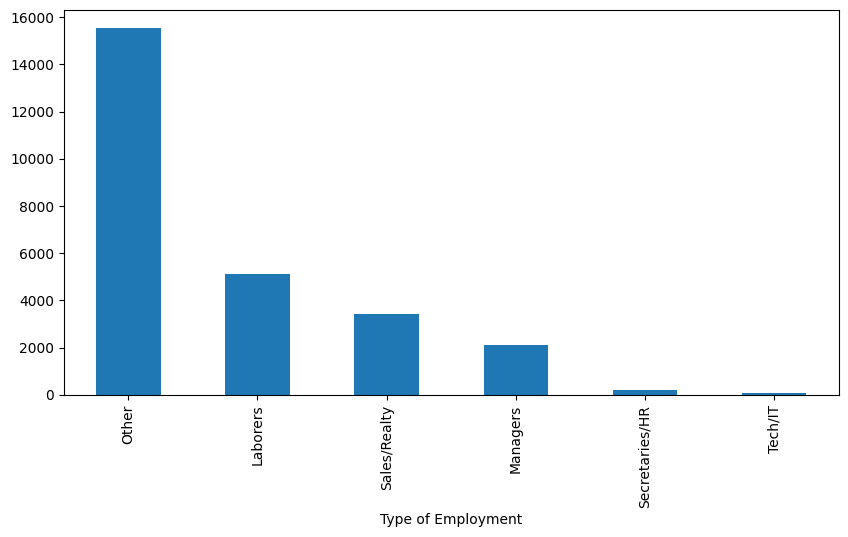

In [36]:
# We visualize the column Type of Employment how many times it repeates
plt.figure(figsize=(10,5))
train['Type of Employment'].value_counts().plot(kind='bar')

In [37]:
# Loop over each column in the DataFrame where dtype is 'object'
for col in train.select_dtypes(include=['object']).columns:

    # Print the column name and the unique values
    print(f"{col}: {train[col].unique()}")

Gender: ['M' 'F']
Income Stability: ['Low' 'High']
Profession: ['Working' 'Pensioner' 'State servant' 'Commercial associate' 'Unemployed']
Type of Employment: ['Other' 'Secretaries/HR' 'Laborers' 'Managers' 'Sales/Realty' 'Tech/IT']
Location: ['Semi-Urban' 'Rural' 'Urban']
Expense Type 1: ['N' 'Y']
Expense Type 2: ['Y' 'N']
Has Active Credit Card: ['Unpossessed' 'Active' 'Inactive']
Property Location: ['Rural' 'Urban' 'Semi-Urban']


# Exploratory Data Analysis

In [38]:
def explore_data(df):
  # Get the names of all columns with data type 'object' (categorical columns)
  cat_vars = df.select_dtypes(include='object').columns.tolist()

  # Create a figure with subplots
  num_cols = len(cat_vars)
  num_rows = (num_cols + 2) // 3
  fig, axs = plt.subplots(nrows=num_rows, ncols=3, figsize=(15, 5*num_rows))
  axs = axs.flatten()

  # Create a countplot for the top 6 values of each categorical variable using Seaborn
  for i, var in enumerate(cat_vars):
      top_values = df[var].value_counts().nlargest(6).index
      filtered_tf = df[df[var].isin(top_values)]
      sns.countplot(x=var, data=filtered_tf, ax=axs[i])
      axs[i].set_title(var)
      axs[i].tick_params(axis='x', rotation=90)

  # Remove any extra empty subplots if needed
  if num_cols < len(axs):
      for i in range(num_cols, len(axs)):
          fig.delaxes(axs[i])

  # Adjust spacing between subplots
  fig.tight_layout()

  # Show plot
  plt.show()

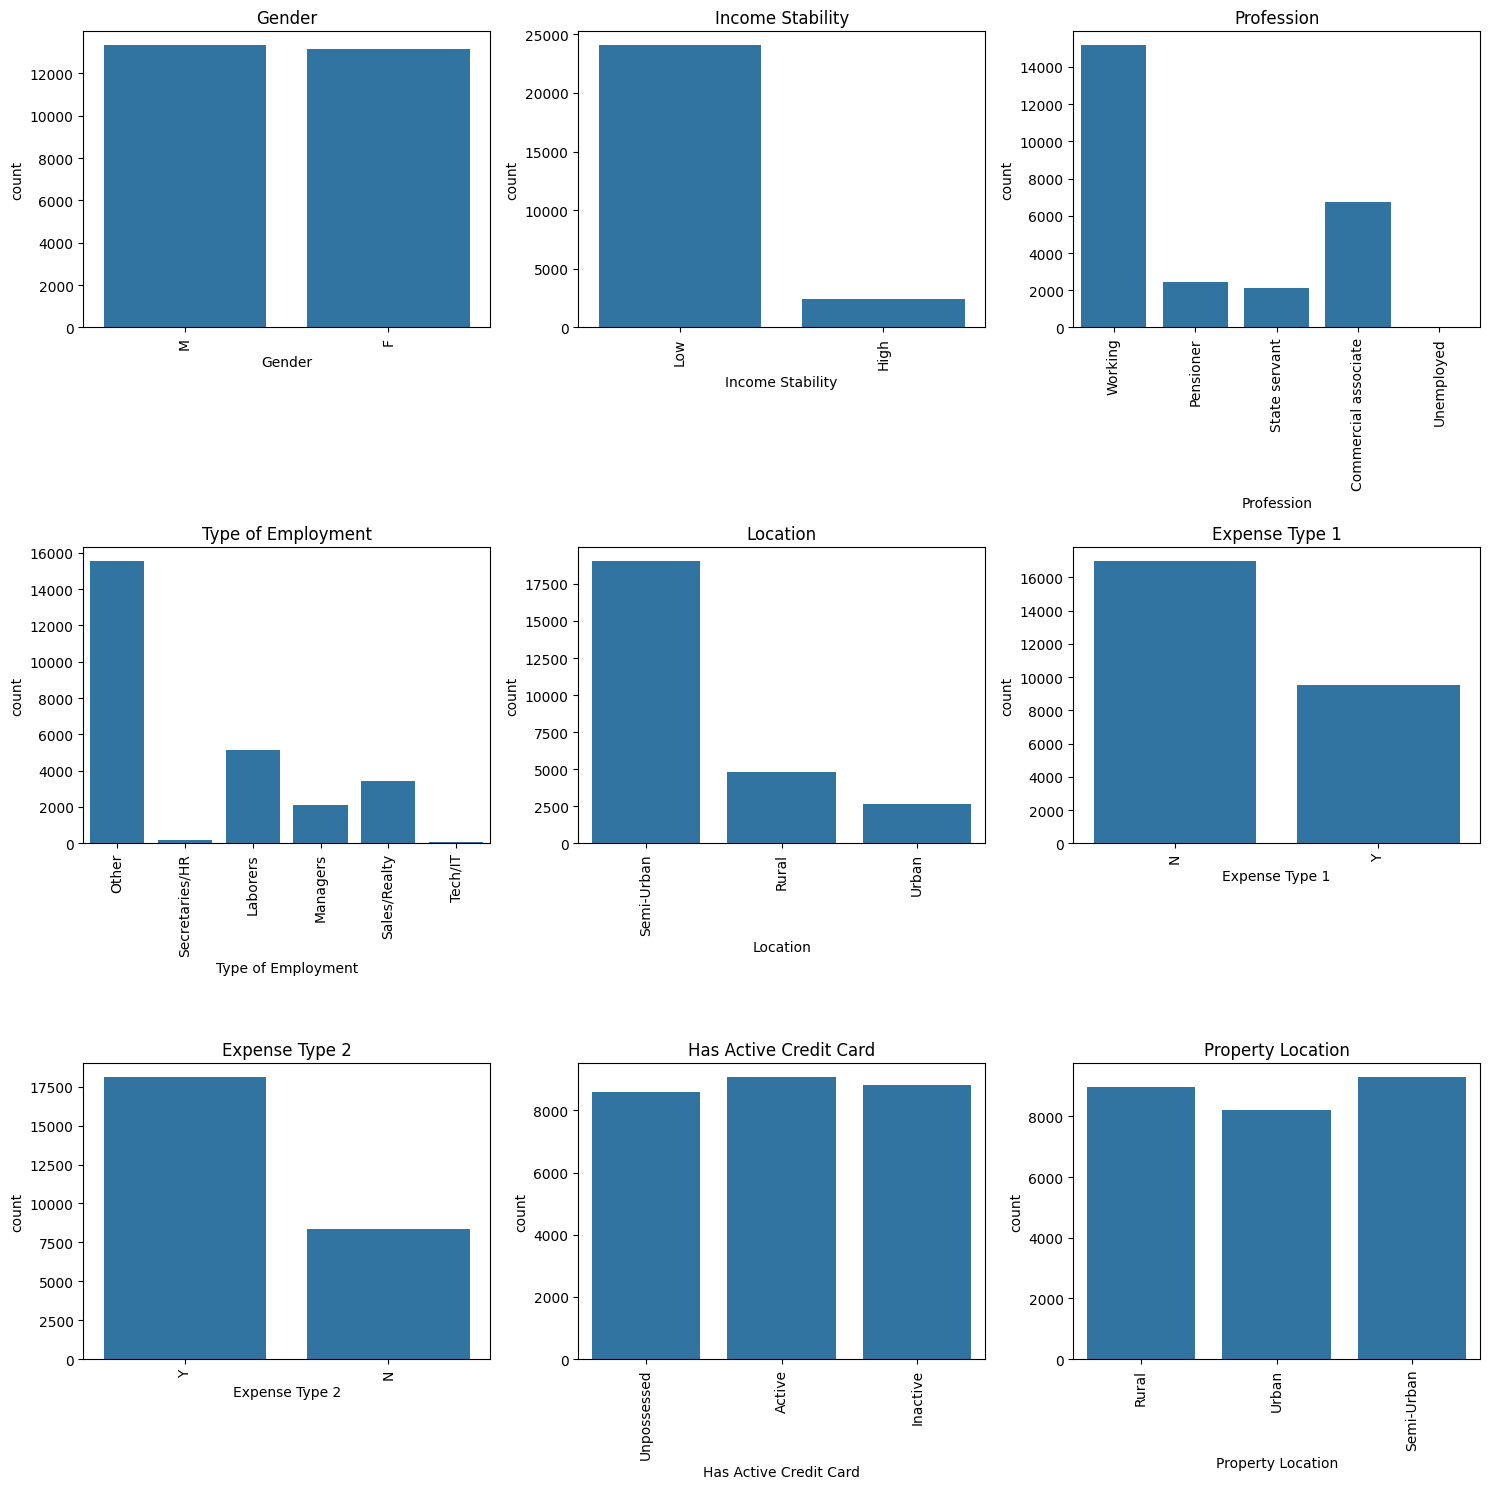

In [39]:
explore_data(train)

In [40]:
def eplore_2(df):
  # Get the names of all columns with data type 'int' or 'float' except 'cltv' and 'marital_status'
  num_vars = df.select_dtypes(include=['int', 'float']).columns.tolist()
  exclude_vars = ['Loan Sanction Amount (USD)']
  num_vars = [var for var in num_vars if var not in exclude_vars]

  # Create a figure with subplots
  num_cols = len(num_vars)
  num_rows = (num_cols + 2) // 3
  fig, axs = plt.subplots(nrows=num_rows, ncols=3, figsize=(15, 5*num_rows))
  axs = axs.flatten()

  # Create a box plot for each numerical variable using Seaborn
  for i, var in enumerate(num_vars):
      sns.boxplot(x=df[var], ax=axs[i])
      axs[i].set_title(var)

  # Remove any extra empty subplots if needed
  if num_cols < len(axs):
      for i in range(num_cols, len(axs)):
          fig.delaxes(axs[i])

  # Adjust spacing between subplots
  fig.tight_layout()

  # Show plot
  plt.show()

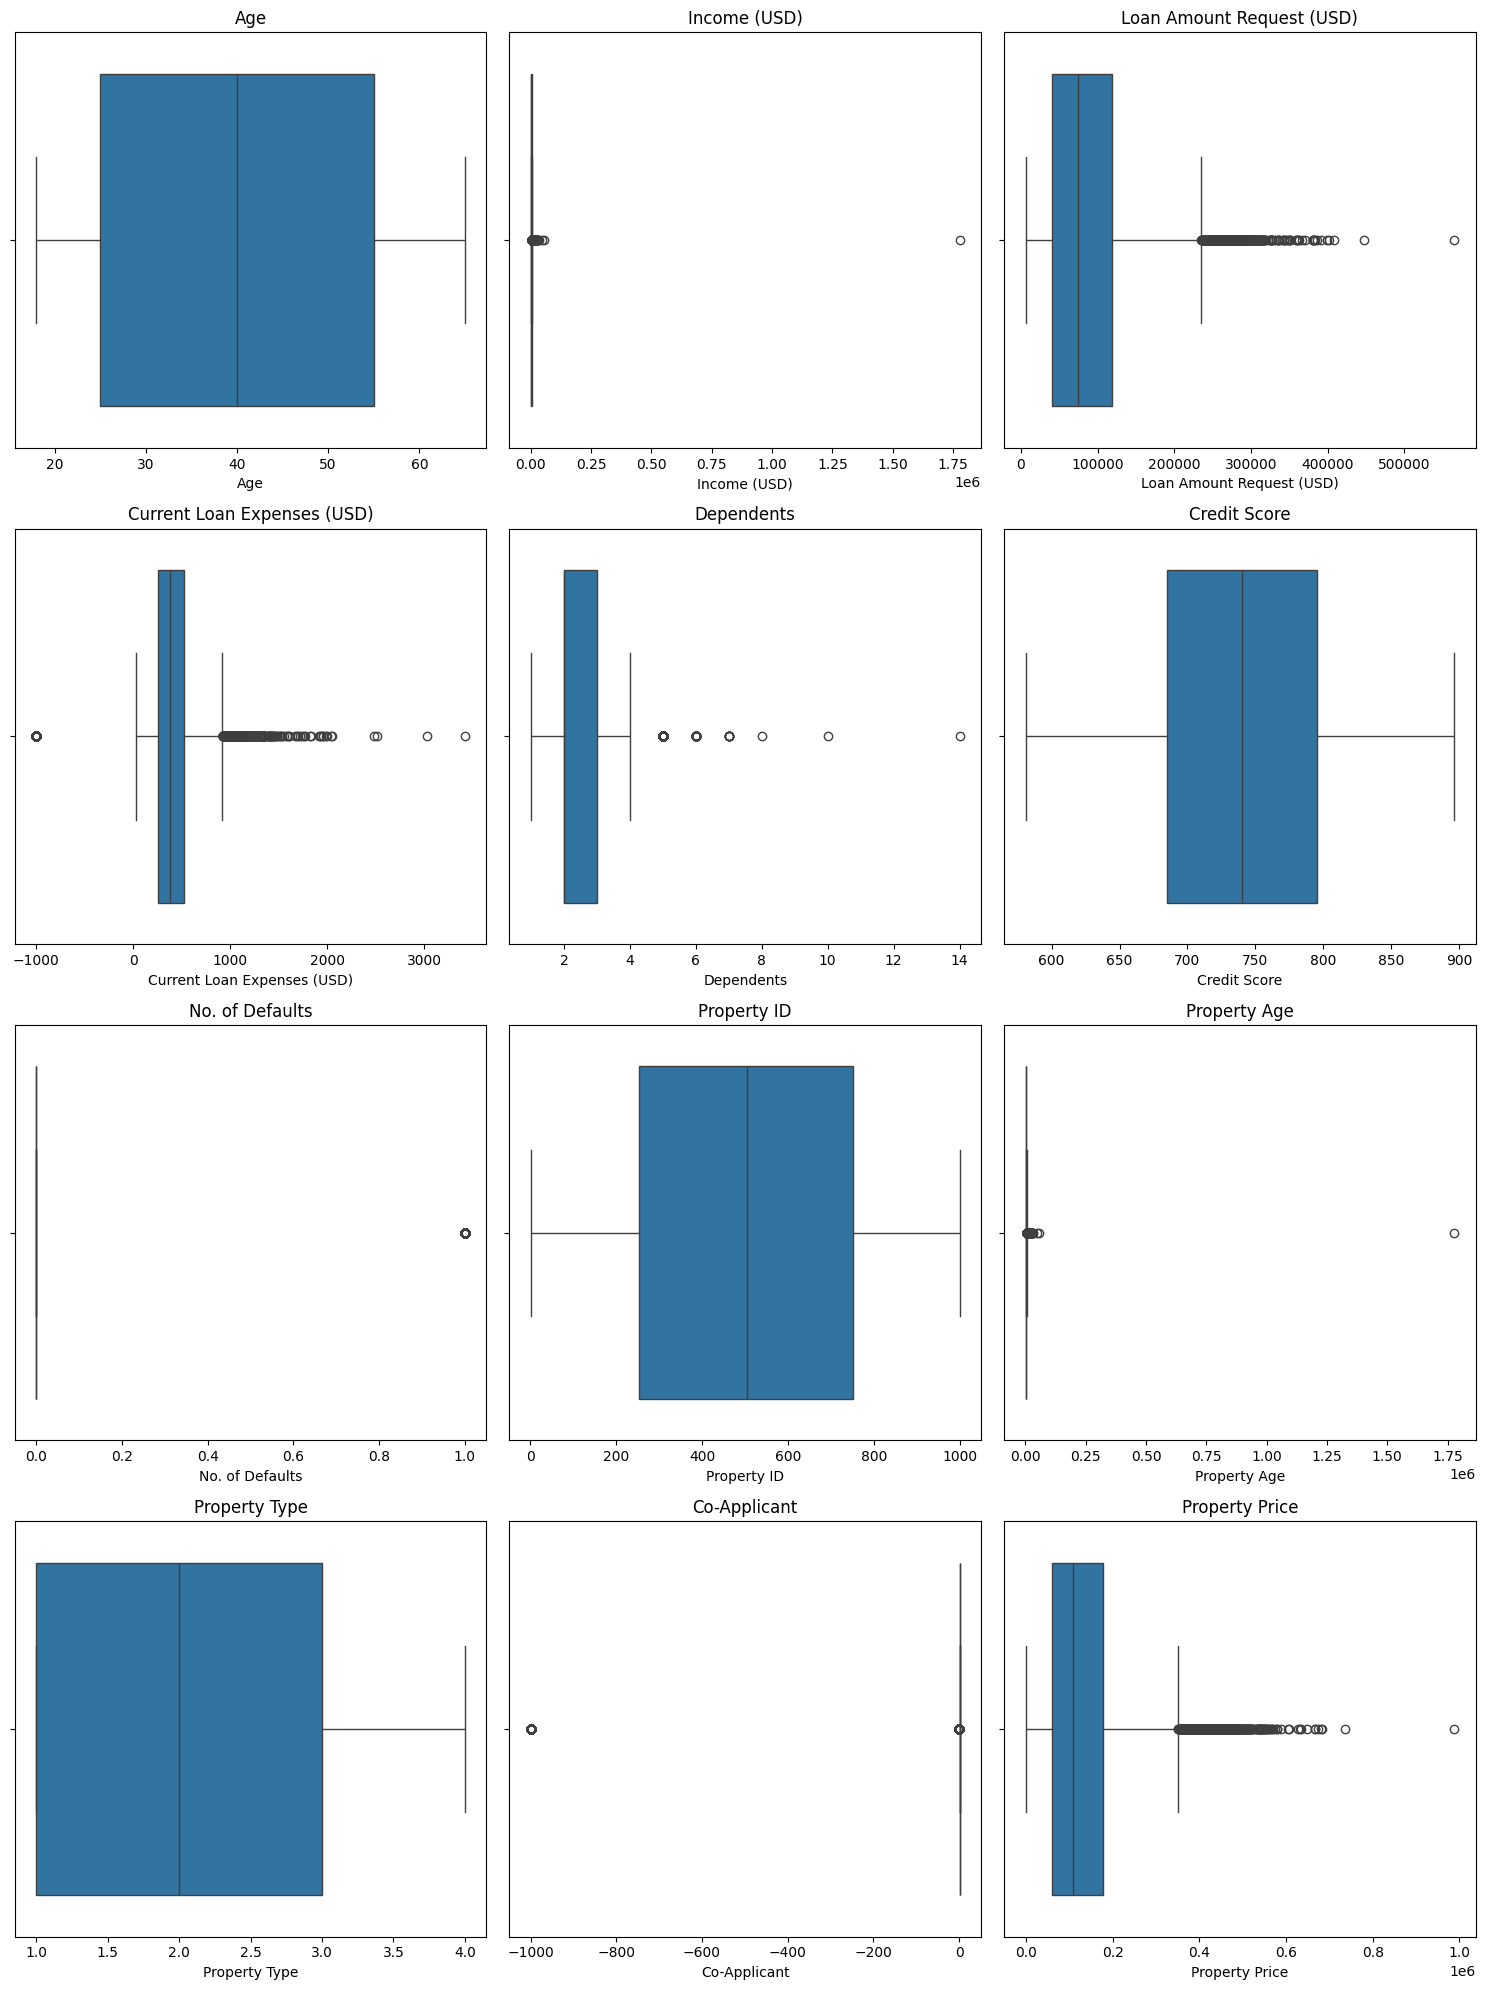

In [41]:
eplore_2(train)

In [42]:
def exprole_3(df):
  # Get the names of all columns with data type 'int' or 'float' except 'marital_status' and 'cltv'
  int_vars = df.select_dtypes(include=['int', 'float']).columns.tolist()
  exclude_vars = ['Loan Sanction Amount (USD)']
  int_vars = [var for var in int_vars if var not in exclude_vars]

  # Create a figure with subplots
  num_cols = len(int_vars)
  num_rows = (num_cols + 2) // 3  # To make sure there are enough rows for the subplots
  fig, axs = plt.subplots(nrows=num_rows, ncols=3, figsize=(15, 5*num_rows))
  axs = axs.flatten()

  # Create a histogram for each integer variable
  for i, var in enumerate(int_vars):
      df[var].plot.hist(ax=axs[i], bins=20)  # You can adjust the number of bins as needed
      axs[i].set_title(var)

  # Remove any extra empty subplots if needed
  if num_cols < len(axs):
      for i in range(num_cols, len(axs)):
          fig.delaxes(axs[i])

  # Adjust spacing between subplots
  fig.tight_layout()

  # Show plot
  plt.show()

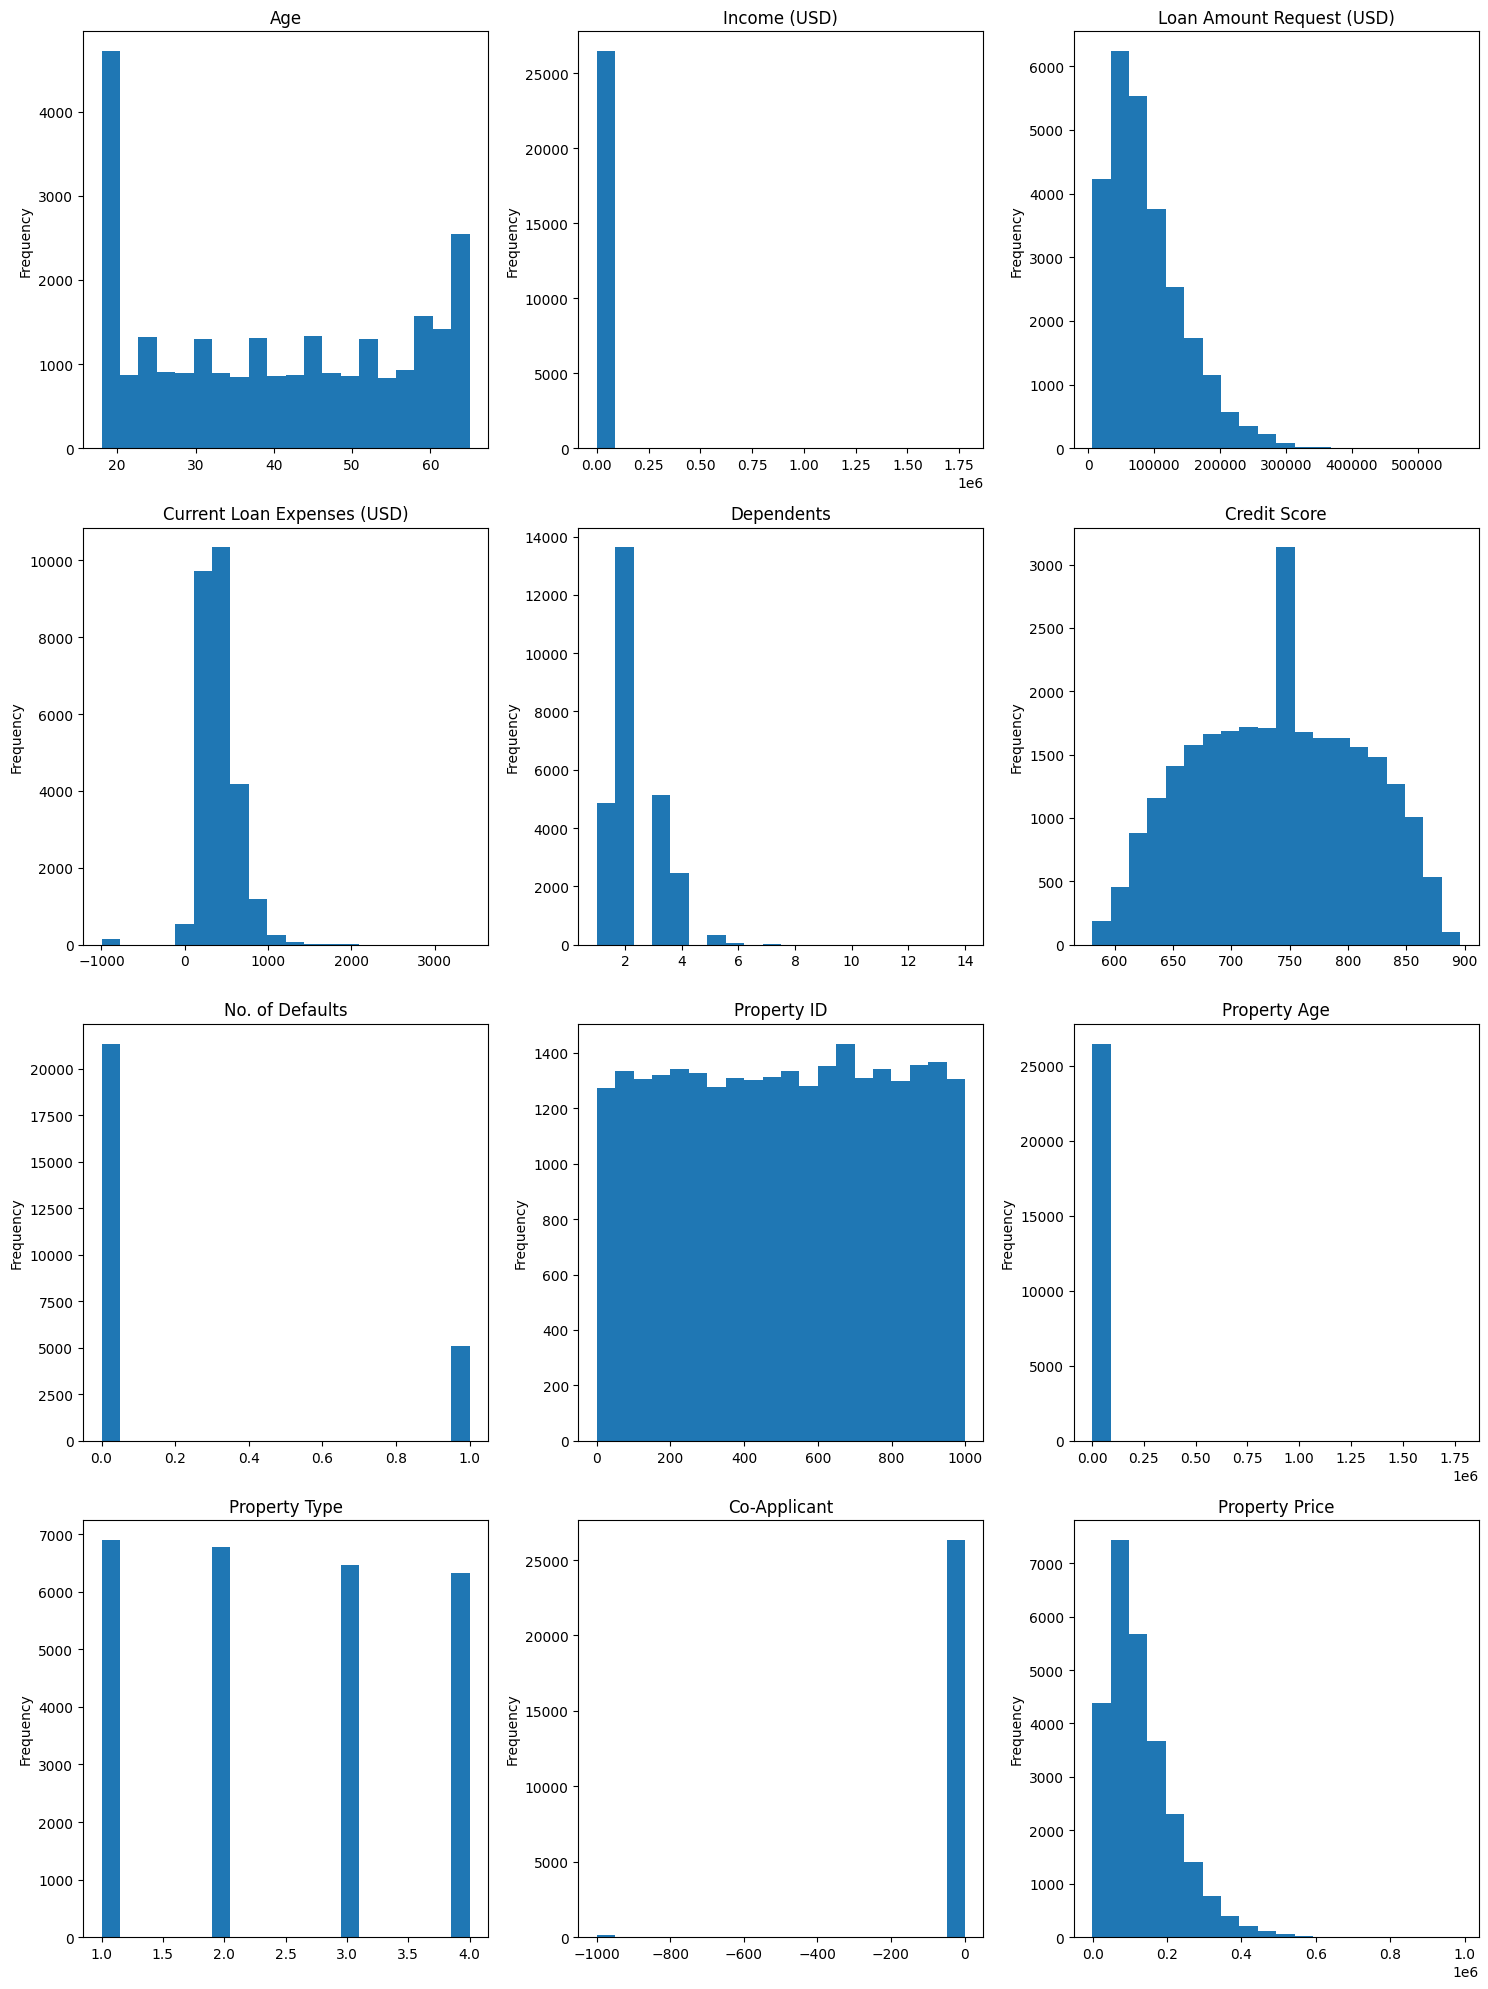

In [43]:
exprole_3(train)

In [44]:
def exprole_4(df):
  # Specify the maximum number of categories to show individually
  max_categories = 5

  # Filter categorical columns with 'object' data type
  cat_cols = [col for col in df.columns if col != 'y' and df[col].dtype == 'object']

  # Create a figure with subplots
  num_cols = len(cat_cols)
  num_rows = (num_cols + 2) // 3
  fig, axs = plt.subplots(nrows=num_rows, ncols=3, figsize=(20, 5*num_rows))

  # Flatten the axs array for easier indexing
  axs = axs.flatten()

  # Create a pie chart for each categorical column
  for i, col in enumerate(cat_cols):
      if i < len(axs):  # Ensure we don't exceed the number of subplots
          # Count the number of occurrences for each category
          cat_counts = df[col].value_counts()

          # Group categories beyond the top max_categories as 'Other'
          if len(cat_counts) > max_categories:
              cat_counts_top = cat_counts[:max_categories]
              cat_counts_other = pd.Series(cat_counts[max_categories:].sum(), index=['Other'])
              cat_counts = pd.concat([cat_counts_top, cat_counts_other])

          # Create a pie chart
          axs[i].pie(cat_counts, labels=cat_counts.index, autopct='%1.1f%%', startangle=90)
          axs[i].set_title(f'{col} Distribution')

  # Remove any extra empty subplots if needed
  if num_cols < len(axs):
      for i in range(num_cols, len(axs)):
          fig.delaxes(axs[i])

  # Adjust spacing between subplots
  fig.tight_layout()

  # Show plot
  plt.show()

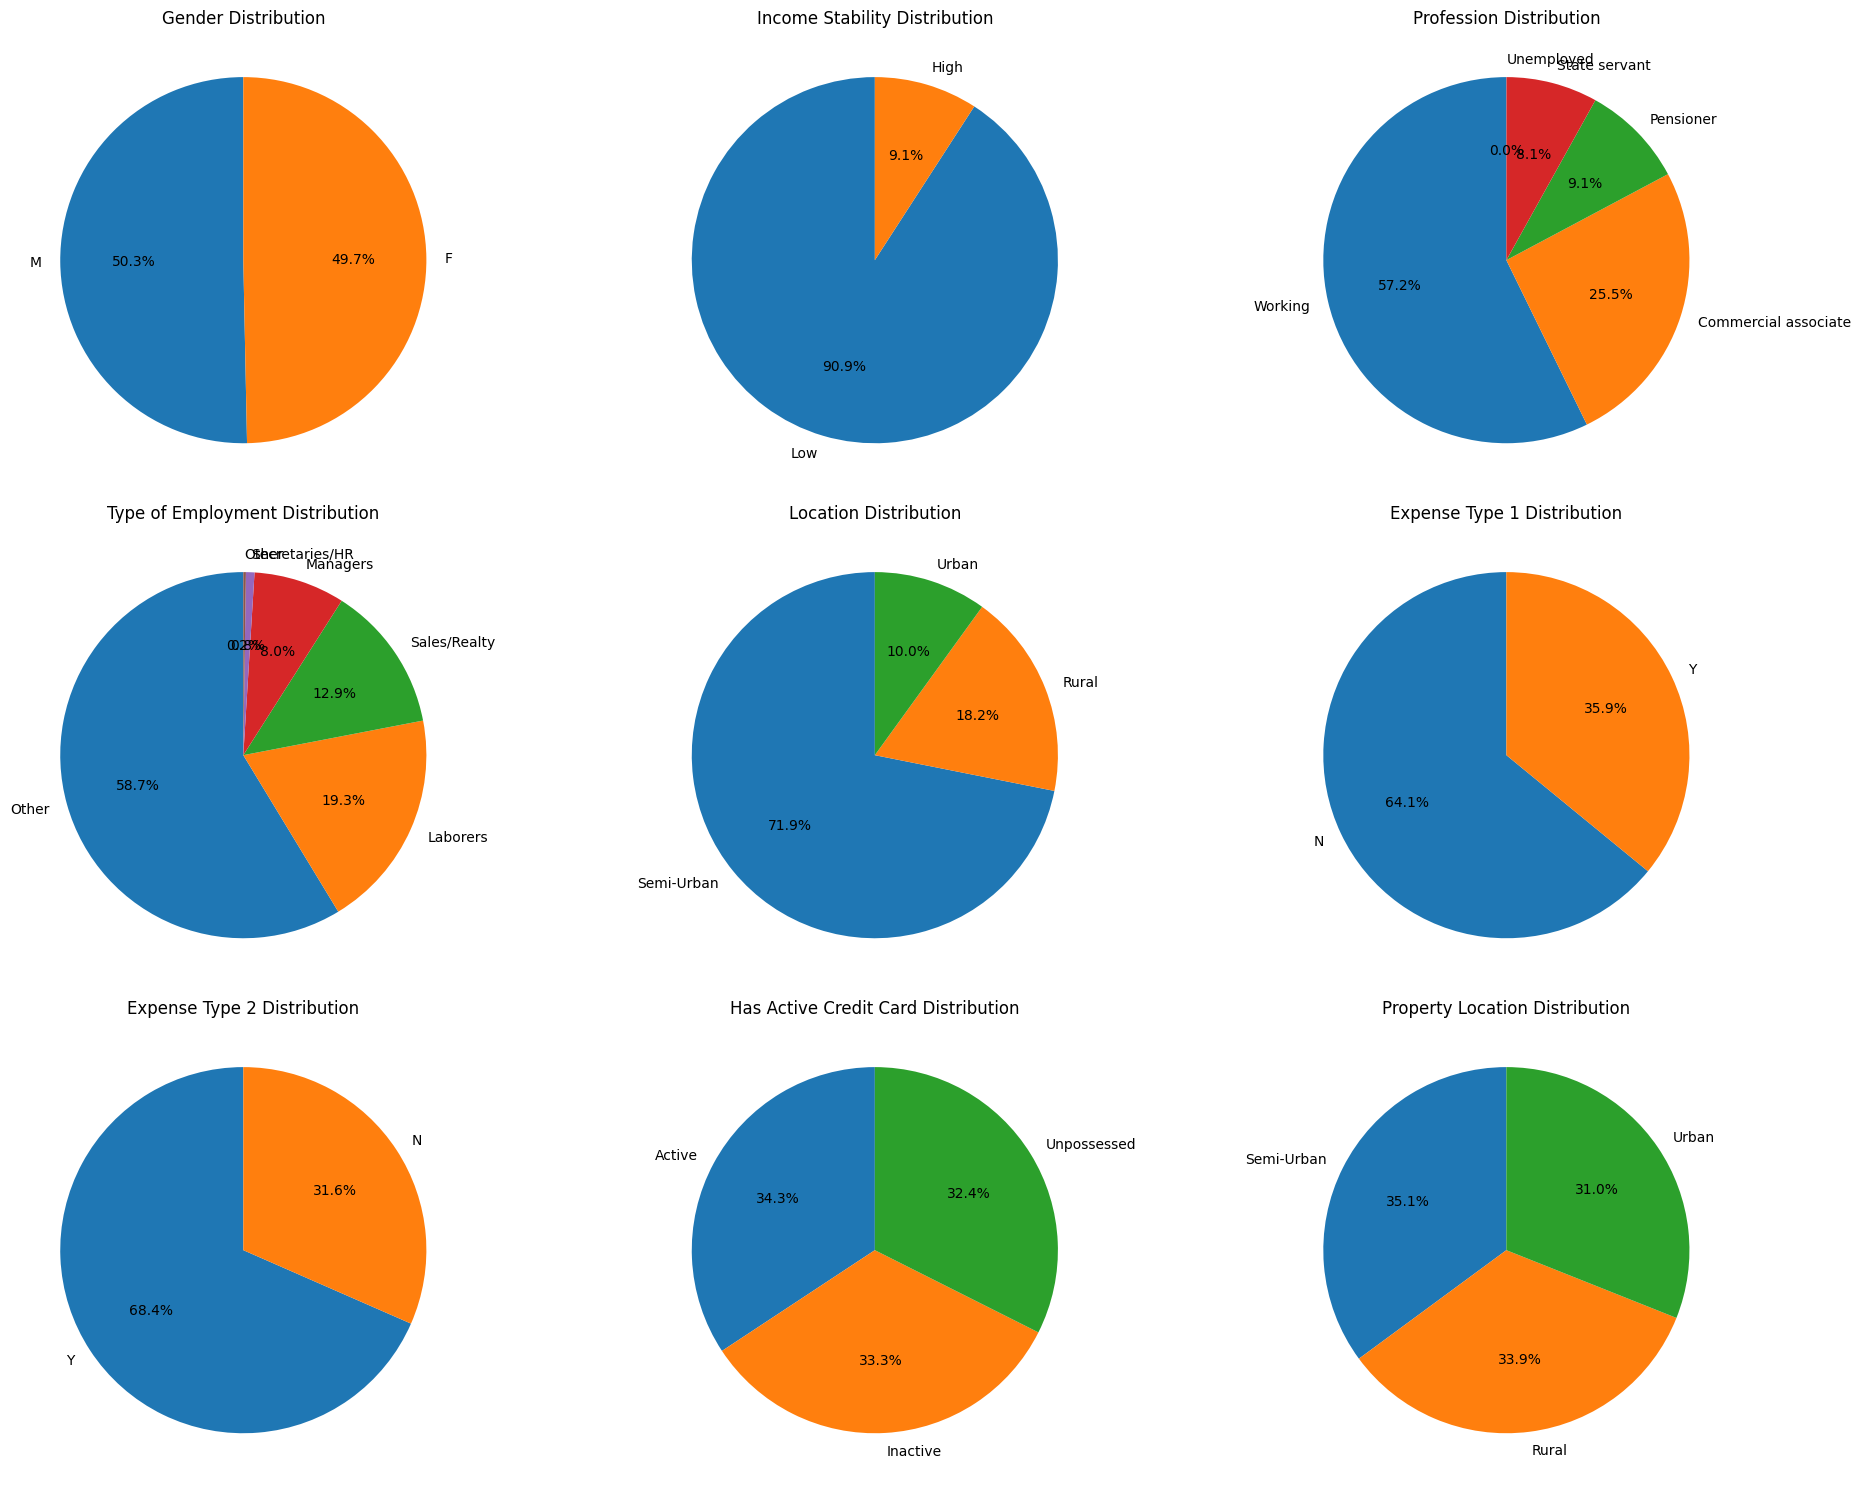

In [45]:
exprole_4(train)

# Data Preprocessing Part 2

In [46]:
# Check the amounnt of missing value
check_missing = train.isnull().sum() * 100 / train.shape[0]
check_missing[check_missing > 0].sort_values(ascending=False)

,0


# Label Encoding for Object Datatypes Encode categorical columns

In [47]:
## Label Encoding for Object Datatypes Encode categorical columns
def encoder_object(df):
    # Loop over each column in the DataFrame where dtype is 'object'
    for col in df.select_dtypes(include=['object']).columns:
        label_encoder = LabelEncoder()

        # Fit the encoder to the unique values in the column
        label_encoder.fit(df[col].unique())

        # Transform the column using the encoder
        df[col] = label_encoder.transform(df[col])

        # Print the column name and the unique encoded values
        print(f"{col}: {df[col].unique()}")

In [48]:
# Print the column name and the unique encoded values
encoder_object(train)

Gender: [1 0]
Income Stability: [1 0]
Profession: [4 1 2 0 3]
Type of Employment: [2 4 0 1 3 5]
Location: [1 0 2]
Expense Type 1: [0 1]
Expense Type 2: [1 0]
Has Active Credit Card: [2 0 1]
Property Location: [0 2 1]


In [49]:
train.shape

(26474, 22)

<Axes: >

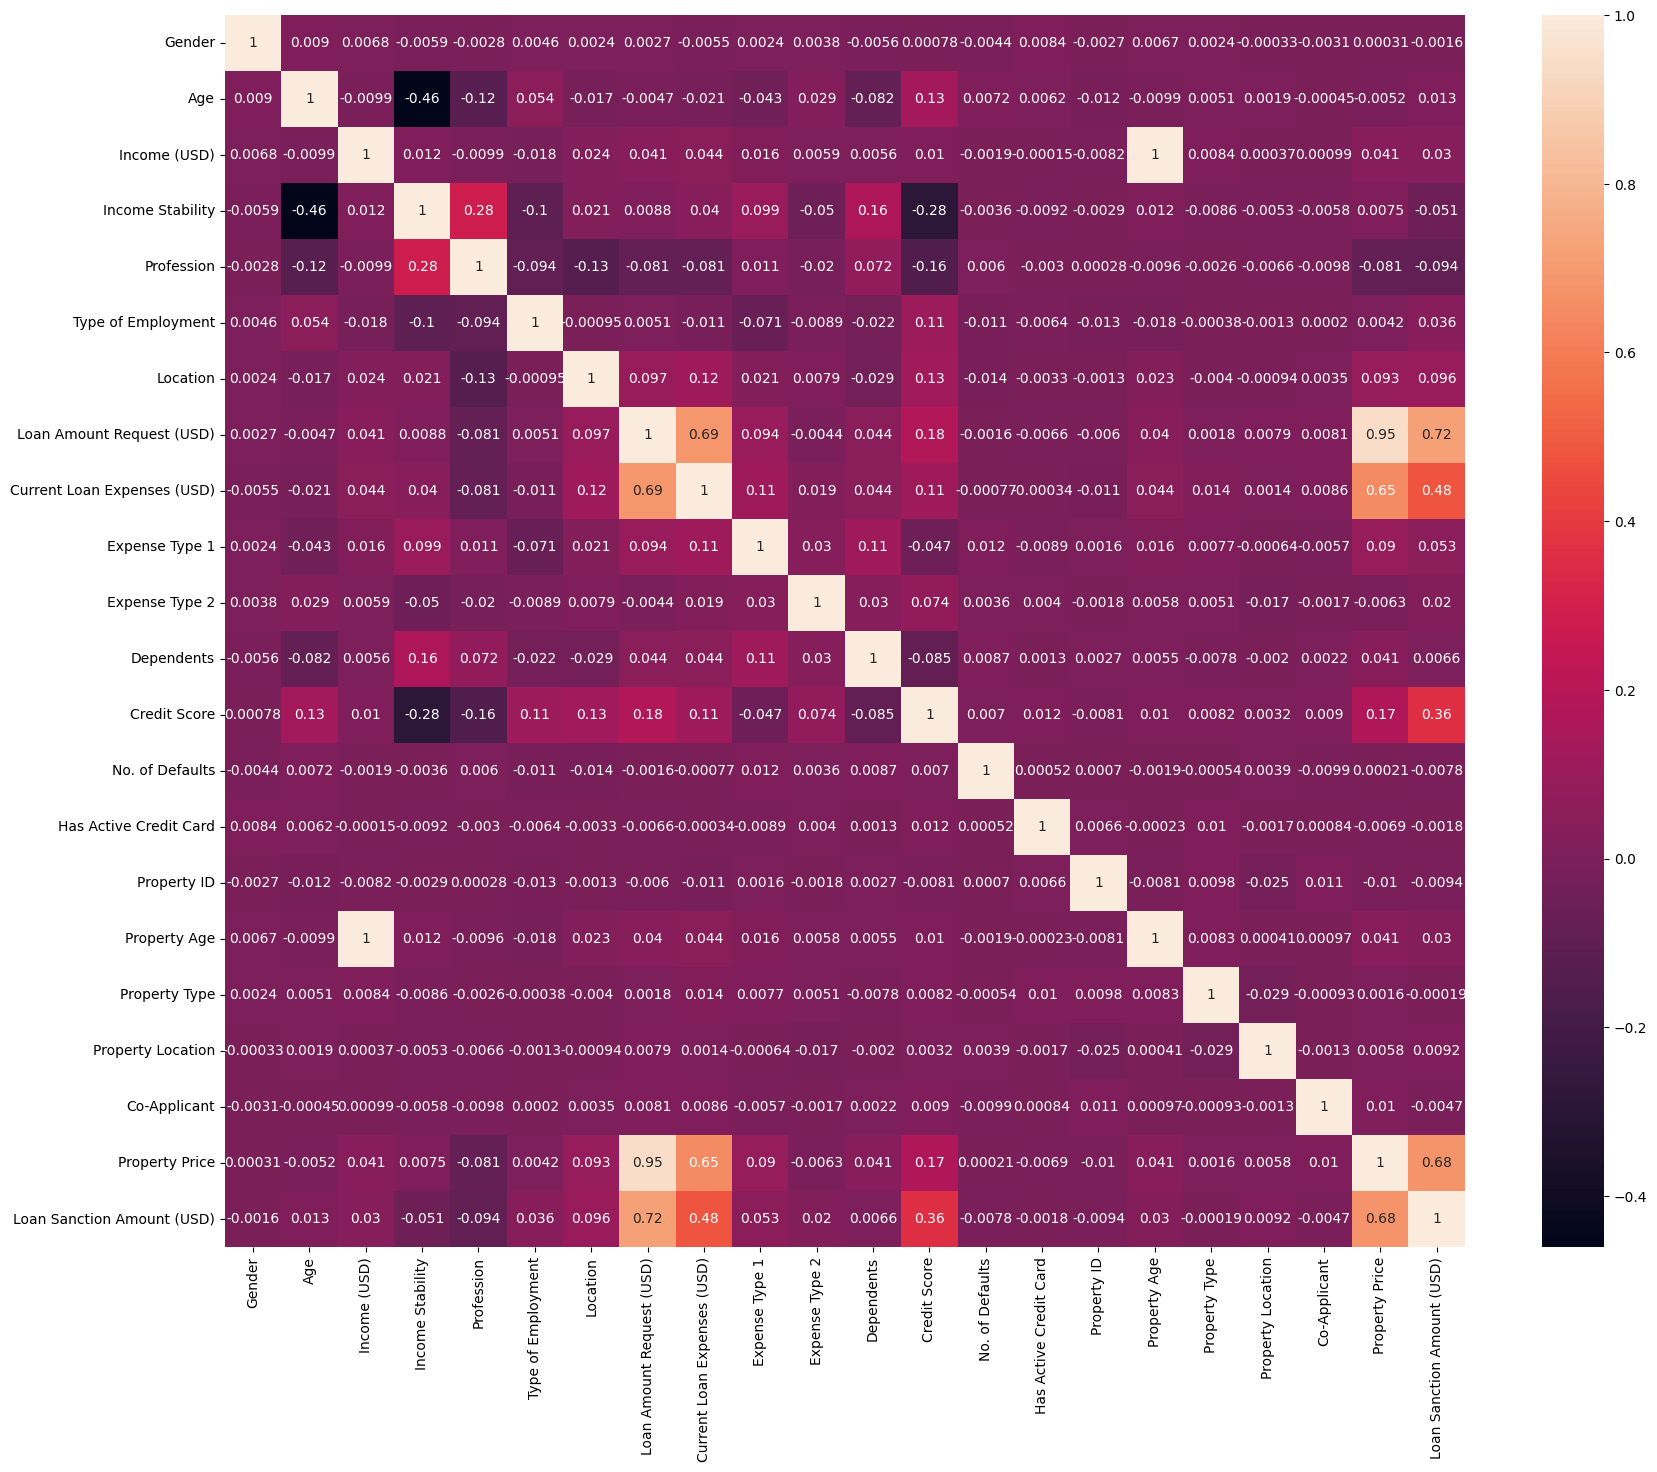

In [50]:
# Correlation Heatmap
plt.figure(figsize=(20, 16))
sns.heatmap(train.corr(), fmt='.2g', annot=True)

# Remove Outlier from Train Data using Z-Score

In [51]:
def remove_outliers(df, columns_to_remove_outliers):
    # Remove outliers using Z-score
    z_scores = np.abs(stats.zscore(df[columns_to_remove_outliers]))
    threshold = 3
    outlier_indices = np.where(z_scores > threshold)[0]
    df = df.drop(df.index[outlier_indices])
    return df.head(10)


In [52]:
selected_columns = ['Income (USD)', 'Loan Amount Request (USD)', 'Current Loan Expenses (USD)',
                    'Dependents', 'Property Age', 'Co-Applicant', 'Property Price']
remove_outliers(train, selected_columns)

,Gender,Age,Income (USD),Income Stability,Profession,Type of Employment,Location,Loan Amount Request (USD),Current Loan Expenses (USD),Expense Type 1,...,Credit Score,No. of Defaults,Has Active Credit Card,Property ID,Property Age,Property Type,Property Location,Co-Applicant,Property Price,Loan Sanction Amount (USD)
1,1,32,4952.910,1,4,2,1,46837.47,495.81,0,...,780.40,0,2,608,4952.91,2,0,1,54791.00,37469.98
2,0,65,988.190,0,1,2,1,45593.04,171.95,0,...,833.15,0,2,546,988.19,2,2,0,72440.58,36474.43
3,0,65,2222.435,0,1,2,0,80057.92,298.54,0,...,832.70,1,2,890,2223.25,2,1,1,121441.51,56040.54
4,0,31,2614.770,1,4,2,1,113858.89,491.41,0,...,745.55,1,0,715,2614.77,4,1,1,208567.91,74008.28
5,0,60,1234.920,1,2,4,0,34434.72,181.48,0,...,684.12,1,1,491,1234.92,2,0,1,43146.82,22382.57
6,1,43,2361.560,1,4,0,1,152561.34,697.67,1,...,637.29,0,2,227,2361.56,1,1,1,221050.80,0.00
7,0,45,2222.435,1,2,1,1,240311.77,807.64,0,...,812.26,0,0,314,2223.25,2,2,1,401040.70,168218.24
8,0,38,1296.070,1,4,2,0,35141.99,155.95,0,...,705.29,1,0,241,1296.07,4,0,1,54903.44,22842.29
9,1,18,1546.170,1,4,0,0,42091.29,500.20,0,...,613.24,0,2,883,1546.17,2,2,1,67993.43,0.00
10,1,18,2416.860,1,2,2,1,25765.72,140.02,0,...,652.41,0,0,325,2416.86,2,0,1,32423.71,16747.72


# Train Test Split
# Build the decision Tree

In [55]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
import pandas as pd

def train_decision_tree(df):
    X = df.drop('Loan Sanction Amount (USD)', axis=1)
    y = df['Loan Sanction Amount (USD)']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    # Base model
    dtree = DecisionTreeRegressor()

    # Grid of hyperparameters
    param_grid = {
        'max_depth': [2, 4, 6, 8],
        'min_samples_split': [2, 4, 6, 8],
        'min_samples_leaf': [1, 2, 3, 4],
        'max_features': [None, 'sqrt', 'log2'],  # Removed 'auto'
        'random_state': [0, 42]
    }

    grid_search = GridSearchCV(dtree, param_grid, cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)

    print("Best Parameters:", grid_search.best_params_)

    # Use the best params directly
    best_params = grid_search.best_params_
    dtree = DecisionTreeRegressor(**best_params)
    dtree.fit(X_train, y_train)

    return dtree, X_test, y_test, X_train, y_train


In [56]:
dtree, X_test, y_test,X_train,y_train  = train_decision_tree(train)

Best Parameters: {'max_depth': 8, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 8, 'random_state': 0}


# Evaluate the decision tree

In [57]:
def evaluate_decision_tree(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    rmse = math.sqrt(mse)

    print('MAE is {}'.format(mae))
    print('MAPE is {}'.format(mape))
    print('MSE is {}'.format(mse))
    print('R2 score is {}'.format(r2))
    print('RMSE score is {}'.format(rmse))

In [58]:
print("Decision Tree Model:")
evaluate_decision_tree(dtree, X_test, y_test)

Decision Tree Model:
MAE is 11818.249085447922
MAPE is 2.1931043974058828e+19
MSE is 578894367.7231159
R2 score is 0.7480556395963638
RMSE score is 24060.223767103995


## Plot The Featrue Impontance


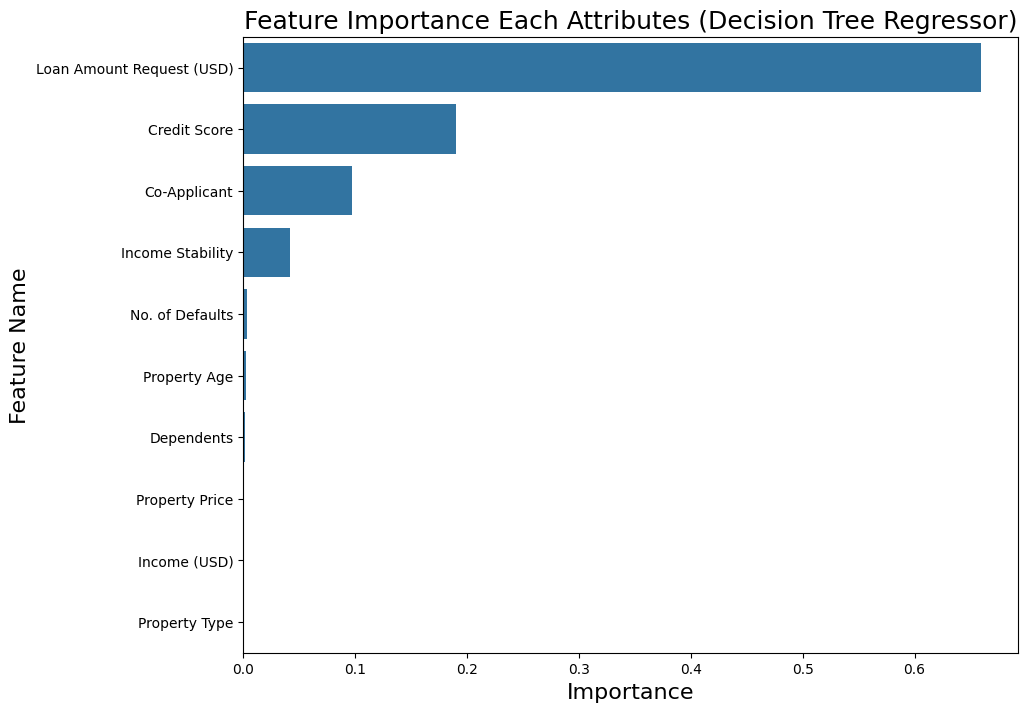

In [59]:
imp_df = pd.DataFrame({
    "Feature Name": X_train.columns,
    "Importance": dtree.feature_importances_
})
fi = imp_df.sort_values(by="Importance", ascending=False)

fi2 = fi.head(10)
plt.figure(figsize=(10,8))
sns.barplot(data=fi2, x='Importance', y='Feature Name')
plt.title('Feature Importance Each Attributes (Decision Tree Regressor)', fontsize=18)
plt.xlabel ('Importance', fontsize=16)
plt.ylabel ('Feature Name', fontsize=16)
plt.show()

In [60]:
!pip install shap

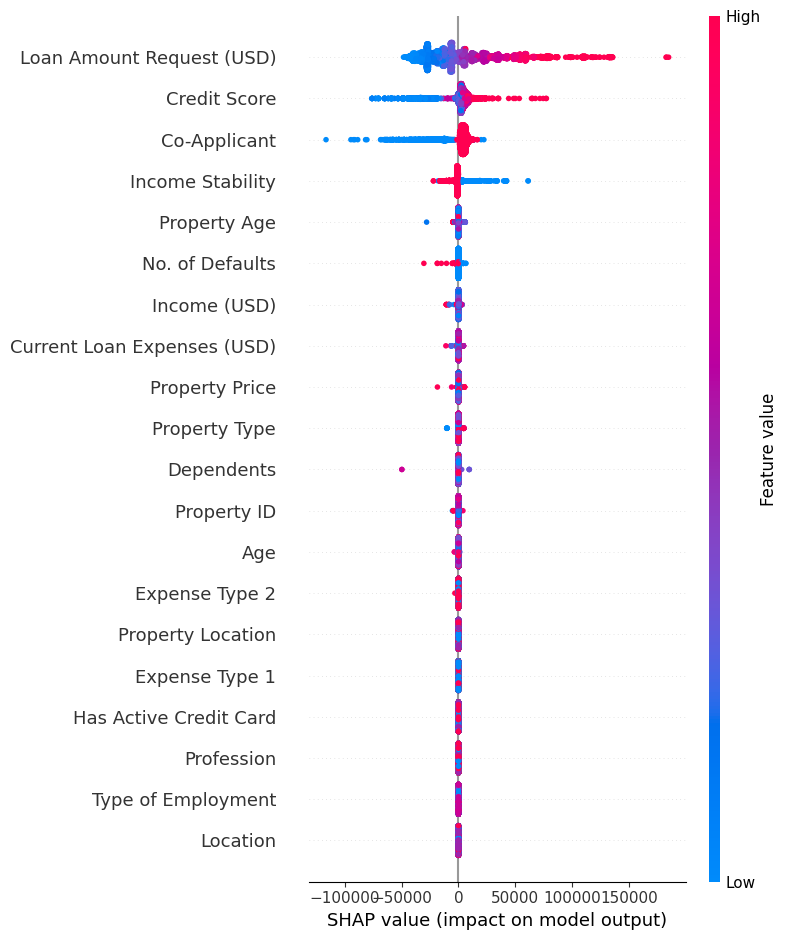

In [61]:
import shap
explainer = shap.TreeExplainer(dtree)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

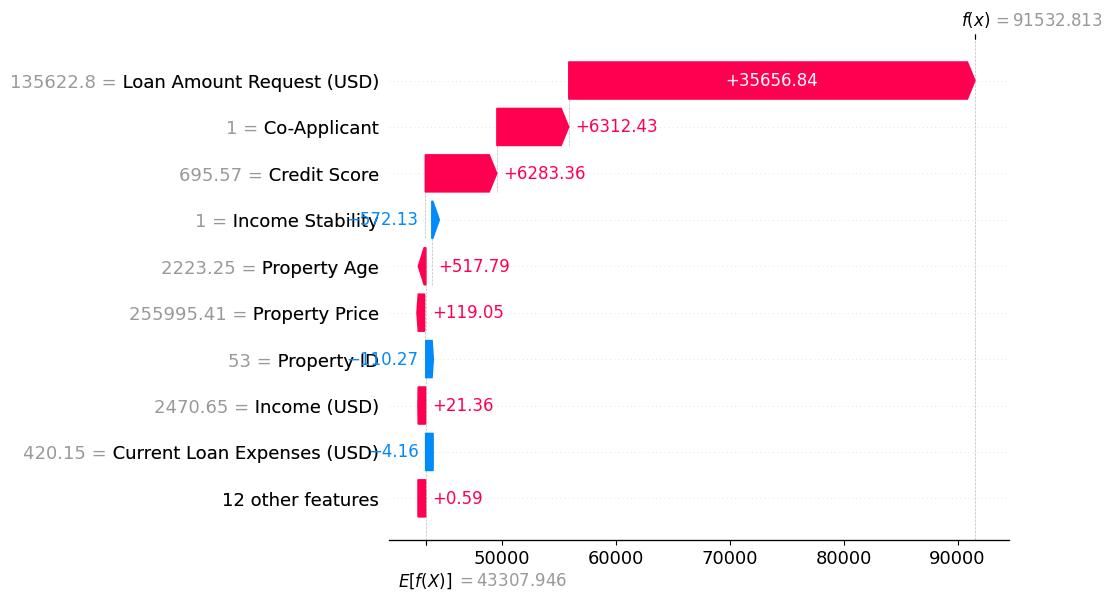

In [62]:
explainer = shap.Explainer(dtree, X_test)
shap_values = explainer(X_test, check_additivity=False)
shap.plots.waterfall(shap_values[0])

# Hyperparameter Tuning

In [67]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

def tune_random_forest(X_train, y_train, n_iter=20):
    rf = RandomForestRegressor(random_state=42, n_jobs=-1)

    # Define the parameter distribution
    param_dist = {
        'max_depth': [3, 5, 7, 9, None],
        'min_samples_split': randint(2, 11),
        'min_samples_leaf': randint(1, 5),
        'max_features': ['sqrt', 1.0]
    }

    # Randomized Search with verbose logging
    rand_search = RandomizedSearchCV(
        estimator=rf,
        param_distributions=param_dist,
        n_iter=n_iter,
        scoring='r2',
        cv=3,
        n_jobs=-1,
        random_state=42,
        verbose=2  # Shows search progress
    )

    rand_search.fit(X_train, y_train)

    print("Best hyperparameters:", rand_search.best_params_)
    return rand_search.best_estimator_

In [68]:
best_rf_model = tune_random_forest(X_train, y_train)
best_rf_model.fit(X_train, y_train)



Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best hyperparameters: {'max_depth': 9, 'max_features': 1.0, 'min_samples_leaf': 2, 'min_samples_split': 7}


RandomForestRegressor(max_depth=9, min_samples_leaf=2, min_samples_split=7,
                      n_jobs=-1, random_state=42)

# Model Evaluation

In [69]:
def evaluate_model(model, X_test, y_test):
    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    rmse = math.sqrt(mse)

    # Print the evaluation metrics
    print('MAE is {}'.format(mae))
    print('MAPE is {}'.format(mape))
    print('MSE is {}'.format(mse))
    print('R2 score is {}'.format(r2))
    print('RMSE score is {}'.format(rmse))

In [70]:
print("Random Forest Model:")
evaluate_model(best_rf_model, X_test, y_test)

Random Forest Model:
MAE is 11666.065102651231
MAPE is 2.1962375299068174e+19
MSE is 553967228.135381
R2 score is 0.758904341173519
RMSE score is 23536.50841002932


# Feature Importance Analysis

In [71]:
def plot_feature_importance(model, X_train):
    imp_df = pd.DataFrame({
        "Feature Name": X_train.columns,
        "Importance": model.feature_importances_
    })
    fi = imp_df.sort_values(by="Importance", ascending=False)
    fi2 = fi.head(10)

    plt.figure(figsize=(10, 8))
    sns.barplot(data=fi2, x='Importance', y='Feature Name')
    plt.title('Feature Importance Each Attributes (Random Forest Regressor)', fontsize=18)
    plt.xlabel('Importance', fontsize=16)
    plt.ylabel('Feature Name', fontsize=16)
    plt.show()


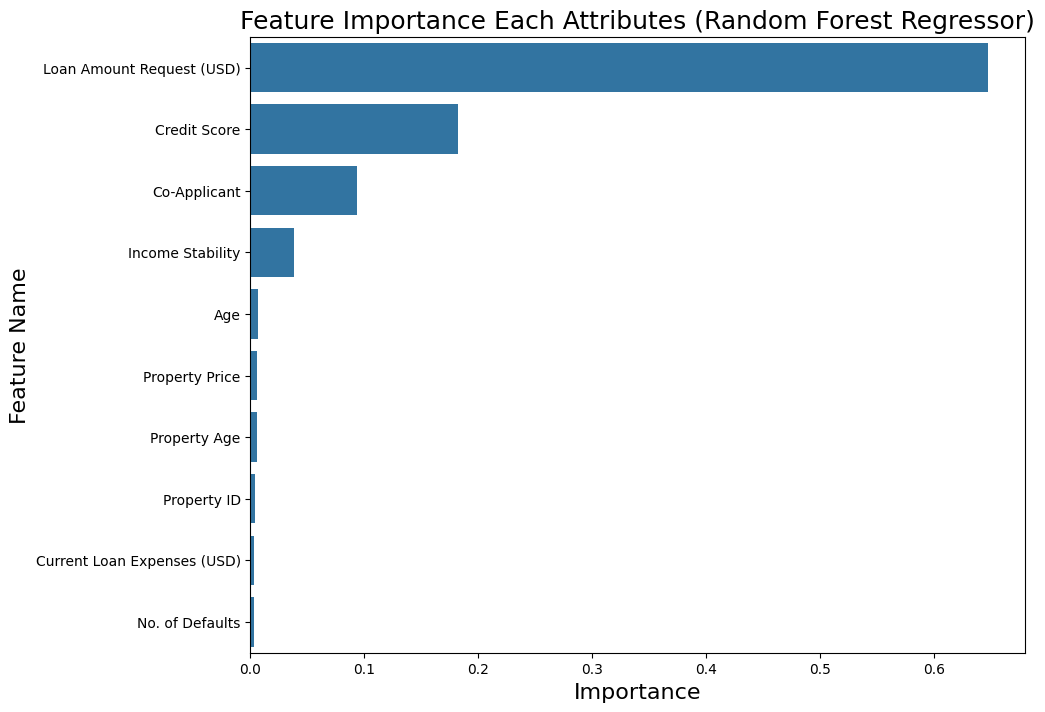

In [72]:
plot_feature_importance(best_rf_model, X_train)

# SHAP Analysis

In [75]:
import shap

def shap_analysis(model, X_test):
    # SHAP Tree Explainer (for tree-based models like Random Forests)
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)

    # Summary Plot
    print('Summary Plot')
    shap.summary_plot(shap_values, X_test)

    # Waterfall Plot for a single instance
    print('\nWaterfall Plot for a single prediction')
    single_instance = X_test.iloc[0] if hasattr(X_test, 'iloc') else X_test[0]

    # For consistent behavior across versions
    shap_values_single = explainer.shap_values(single_instance)
    shap.plots.waterfall(shap.Explanation(values=shap_values_single,
                                          base_values=explainer.expected_value,
                                          data=single_instance))


In [ ]:
shap_analysis(best_rf_model, X_train)

# Compare models based on performance metrics

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
# Compare models based on performance metrics
def compare_models(model1_metrics, model2_metrics):
    metrics_to_compare = ['MAE', 'MAPE', 'MSE', 'R2', 'RMSE']
    for metric in metrics_to_compare:
        if model1_metrics[metric] < model2_metrics[metric]:
            print(f"{metric}: Decision Tree model performs better")
        elif model1_metrics[metric] > model2_metrics[metric]:
            print(f"{metric}: Random Forest model performs better")
        else:
            print(f"{metric}: Both models perform equally")

# Get performance metrics for Decision Tree model
y_pred_dtree = dtree.predict(X_test)
dtree_metrics = {
    'MAE': mean_absolute_error(y_test, y_pred_dtree),
    'MAPE': mean_absolute_percentage_error(y_test, y_pred_dtree),
    'MSE': mean_squared_error(y_test, y_pred_dtree),
    'R2': r2_score(y_test, y_pred_dtree),
    'RMSE': math.sqrt(mean_squared_error(y_test, y_pred_dtree))
}

# Get performance metrics for Random Forest model
y_pred_rf = best_rf_model.predict(X_test)
rf_metrics = {
    'MAE': mean_absolute_error(y_test, y_pred_rf),
    'MAPE': mean_absolute_percentage_error(y_test, y_pred_rf),
    'MSE': mean_squared_error(y_test, y_pred_rf),
    'R2': r2_score(y_test, y_pred_rf),
    'RMSE': math.sqrt(mean_squared_error(y_test, y_pred_rf))
}

# Compare models
print("\nModel Comparison:")
compare_models(dtree_metrics, rf_metrics)

# Select the best model based on the comparison
if dtree_metrics['MAE'] < rf_metrics['MAE']:
    best_model = dtree
else:
    best_model = best_rf_model

print("\nBest Model Selected:")
print(best_model)

# Lets See How The Model Predicts The Train Data and by how what percentage

In [ ]:
# Assuming you have 'new_data' in the same format as your training data
X_new = train.drop('Loan Sanction Amount (USD)', axis=1)
y_new_actual = train['Loan Sanction Amount (USD)']

# Use the model to make predictions on the new data
y_new_pred = best_model.predict(X_new)

# Evaluate the model on the new data
new_data_metrics = {
    'MAE': mean_absolute_error(y_new_actual, y_new_pred),
    'MAPE': mean_absolute_percentage_error(y_new_actual, y_new_pred),
    'MSE': mean_squared_error(y_new_actual, y_new_pred),
    'R2': r2_score(y_new_actual, y_new_pred),
    'RMSE': math.sqrt(mean_squared_error(y_new_actual, y_new_pred))
}

# Print the evaluation metrics for the new data
print("\nEvaluation Metrics on New Data:")
print(new_data_metrics)

MAE (Mean Absolute Error): MAE measures the average absolute difference between the actual values and the predicted values. It gives you an idea of how far off, on average, your predictions are from the actual values. In this case, the MAE is approximately 10,671.91.

MAPE (Mean Absolute Percentage Error): MAPE is a percentage-based error metric that measures the average percentage difference between the actual values and the predicted values. The value you've provided, 2.047173595112394e+19, is extremely high and likely indicates an issue with the model's predictions. Such a high MAPE suggests that the model's predictions are significantly off from the actual values.

MSE (Mean Squared Error): MSE measures the average squared difference between the actual values and the predicted values. It penalizes larger errors more than smaller ones. The MSE in this case is approximately 461,443,783.14.

R2 (R-squared): R-squared is a measure of how well the model explains the variance in the data. It ranges from 0 to 1, where 1 indicates a perfect fit. An R-squared value of 0.7929 suggests that the model explains about 79.29% of the variance in the data, which is relatively good.

RMSE (Root Mean Squared Error): RMSE is the square root of the MSE and is in the same units as the target variable. It provides a measure of the average magnitude of errors. The RMSE in this case is approximately 21,481.24.

In summary, while the R-squared value indicates that the model is explaining a significant portion of the variance in the data, the extremely high MAPE suggests that the model's predictions are not accurate on a percentage basis.

  # USING The Best Model To Predict.

First we need to prepare the data. in the formart we can use to predict the new data end evaluate the performance

#This  is evaluation of the best model on new data

in preapraing the data we first transform the data into the form that will be accepted by the model

#### Steps taken to prepare the testing data.
test.head()

#### Check the number of unique value from all of the object datatype
test.select_dtypes(include='object').nunique()

#### Check the amounnt of missing value
check_missing = test.isnull().sum() * 100 / test.shape[0]
check_missing[check_missing > 0].sort_values(ascending=False)

#### check segmet of employment type
test['Type of Employment'].unique()

#### if not formarted apply this

test['Type of Employment'] = test['Type of Employment'].apply(segment_employment_type)

#### Processing the new Test Data
preprocess_data(test)

#### Loop over each column in the DataFrame where dtype is 'object'
for col in test.select_dtypes(include=['object']).columns:

####     Print the column name and the unique values
###### _________    print(f"{col}: {test[col].unique()}")

exprole the testing data

explore_data(test)

eplore_2(test)

exprole_3(test)

exprole_4(test)

#### unique encoded values

encoder_object(test)

test.shape

#### Remove outliers using Z-Score
remove_outliers(test, selected_columns)




In [ ]:
test.head()

In [ ]:
#### Check the number of unique value from all of the object datatype
test.select_dtypes(include='object').nunique()

In [ ]:

#### Check the amounnt of missing value
check_missing = test.isnull().sum() * 100 / test.shape[0]
check_missing[check_missing > 0].sort_values(ascending=False)

In [ ]:
#### check segmet of employment type
test['Type of Employment'].unique()

In [ ]:

#### if segment not formarted apply this

test['Type of Employment'] = test['Type of Employment'].apply(segment_employment_type)

test['Type of Employment'].unique()

In [ ]:
def preprocess_data(df):
    # Remove identifier columns
    df.drop(columns=['Customer ID', 'Name'], inplace=True)

    # Segment Type of Employment into smaller unique values
    df['Type of Employment'] = df['Type of Employment'].apply(segment_employment_type)



    # Handle missing values
    df.fillna({
        'Property Age': df['Property Age'].median(),
        'Income (USD)': df['Income (USD)'].median(),
        'Dependents': df['Dependents'].median(),
        'Credit Score': df['Credit Score'].median(),
        'Current Loan Expenses (USD)': df['Current Loan Expenses (USD)'].median()
    }, inplace=True)

    df.dropna(subset=['Income Stability', 'Has Active Credit Card', 'Property Location', 'Gender'], inplace=True)

    return df.head(10)

In [ ]:
#### Processing the new Test Data
preprocess_data(test)

In [ ]:
#### Loop over each column in the DataFrame where dtype is 'object'
for col in test.select_dtypes(include=['object']).columns:

    # Print the column name and the unique values
    print(f"{col}: {test[col].unique()}")

# exprole the testing data

In [ ]:
test.dtypes

In [ ]:
explore_data(test)

In [ ]:
eplore_2(test)

In [ ]:
exprole_3(test)

In [ ]:
exprole_4(test)

In [ ]:
#### unique encoded values

encoder_object(test)

In [ ]:
test.shape

In [ ]:
#### Remove outliers using Z-Score
remove_outliers(test, selected_columns)

# Use the model to make predictions on the new data

Lets first copy the test data to new data so to avoid termparing with the data

In [ ]:
new_data = test.copy()

In [ ]:

# Assuming 'new_data' doesn't contain the 'Loan Sanction Amount (USD)' column
X_new = new_data  # Replace 'new_data' with your actual new data

# Use the model to make predictions on the new data
y_new_pred = best_model.predict(X_new)

# Create a new column in 'new_data' and populate it with the predicted values
new_data['Predicted Loan Sanction Amount (USD)'] = y_new_pred

# Save the data with the predicted column to a CSV file
test_data_predicted = new_data.to_csv('test_data_with_predictions.csv', index=False)  # Change the filename as needed

# Lets Predict Loan Sanction For an Individual

In [ ]:
def predict_loan_sanction_amount():
    # Prompt the user to input values for each feature
    print("Please enter the following information:")
    print('Example First Name')
    client_name = input('Type Your Name: ') or None
    gender = input("Gender (1-Male/0-Female): ")
    age = int(input("Age: "))
    income_usd = float(input("Income (USD): "))
    income_stability = input("Income Stability (0 - Stable/1- Unstable): ")

    print("4 - 'Working', 1- 'Pensioner', 2-'State servant', 0 - 'Commercial associate', 3- 'Unemployed'")
    profession = input("Profession: ")
    print ("Employment : 7 -'Unknown', 3- 'Other', 5- 'Secretaries/HR', 1-  'Laborers',2- 'Managers', 0- 'Hospitality',4-  'Sales/Realty' ,6- 'Tech/IT'")
    type_of_employment = input("Type of Employment: ")

    print("1 - 'Semi-Urban', 0-'Rural', 2- 'Urban'")
    location = input("Location: ")

    loan_amount_requested = float(input("Loan Amount Requested (USD): "))
    current_loan_expenses_usd = float(input("Current Loan Expenses (USD): "))

    expense_type_1 = input("Expense Type 1 (1- Yes, 0 - No): ")

    expense_type_2 = input("Expense Type 2 (1- Yes, 0 - No): ")

    dependents = (input("Dependents(example: 8.9, 2.0..): "))
    credit_score = float(input("Credit Score: "))
    num_of_defaults = int(input("No. of Defaults: "))

    has_active_credit_card = input("Has Active Credit Card (2 - 'Unpossessed', 0- 'Active', 1-  'Inactive'): ")

    property_id = input("Property ID: ")
    property_age = float(input("Property Age: "))

    property_type = input("Property Type (1 - 4): ")

    property_location = input("Property Location (0- Rural, 1- Semiurban, 2- Urban): ")

    co_applicant = input("Co-Applicant (1 - Yes/0 - No): ")

    property_price = float(input("Property Price: "))

    # Create a dictionary with input values
    input_data = {
        'Gender': [gender],
        'Age': [age],
        'Income (USD)': [income_usd],
        'Income Stability': [income_stability],
        'Profession': [profession],
        'Type of Employment': [type_of_employment],
        'Location': [location],
        'Loan Amount Request (USD)': [loan_amount_requested],
        'Current Loan Expenses (USD)': [current_loan_expenses_usd],
        'Expense Type 1': [expense_type_1],
        'Expense Type 2': [expense_type_2],
        'Dependents': [dependents],
        'Credit Score': [credit_score],
        'No. of Defaults': [num_of_defaults],
        'Has Active Credit Card': [has_active_credit_card],
        'Property ID': [property_id],
        'Property Age': [property_age],
        'Property Type': [property_type],
        'Property Location': [property_location],
        'Co-Applicant': [co_applicant],
        'Property Price': [property_price]
    }

    # Create a DataFrame from the input data
    input_df = pd.DataFrame(input_data)

    # Preprocess the input data (similar to training data preprocessing)
    # ... (apply the same preprocessing steps as in your original code)

    # Use the model to make predictions on the preprocessed input data
    predicted_loan_sanction_amount = best_model.predict(input_df)

    # Display the predicted 'Loan Sanction Amount (USD)'
    print(f"\n Predicted Loan Sanction Amount (USD) for {client_name} : {predicted_loan_sanction_amount[0]:.2f}")


\

In [ ]:
# Call the function to predict 'Loan Sanction Amount (USD)' for an individual
predict_loan_sanction_amount()